In [ ]:
from google.colab import drive
import zipfile
import pandas as pd
import numpy as np

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/time series project/best_track.csv')

df_unique_cyclone = df.drop_duplicates(subset=['cyclone_id'], keep='first')
df_unique_cyclone['month'] = df_unique_cyclone['datetime'].astype(str).str[4:6]
df_unique_cyclone['month'] = df_unique_cyclone['month'].astype(int)
df_unique_cyclone.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,cyclone_id,datetime,flag,intensity,latitude,longitude,num_data_lines,pressure,revision_date,storm_name,time_interval,track_sequence,wind,month
0,CYC000001,1949011300,0,0,57,1399,49,1006,20110729.0,Carmen,6,1,0,1
49,CYC000002,1949061200,0,0,66,1450,50,1008,20110729.0,Della,6,1,0,6
99,CYC000003,1949062006,0,1,213,1218,10,1000,20110729.0,(nameless),6,1,12,6
109,CYC000004,1949063000,0,0,55,1403,43,1008,20110729.0,Elaine,6,1,0,6
152,CYC000005,1949071018,0,0,191,1418,35,1006,20110729.0,Faye,6,1,0,7


In [ ]:
df_unique_cyclone.columns

Index(['cyclone_id', 'datetime', 'flag', 'intensity', 'latitude', 'longitude',
       'num_data_lines', 'pressure', 'revision_date', 'storm_name',
       'time_interval', 'track_sequence', 'wind'],
      dtype='object')

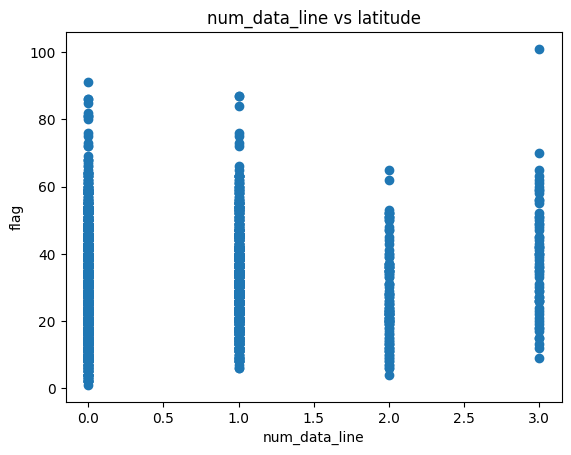

In [ ]:
# prompt: plot num_data_line and latitude

import matplotlib.pyplot as plt

plt.scatter(df_unique_cyclone['flag'] , df_unique_cyclone['num_data_lines'])
plt.xlabel('num_data_line')
plt.ylabel('flag')
plt.title('num_data_line vs latitude')
plt.show()


Root Mean Squared Error (RMSE): 13.5684


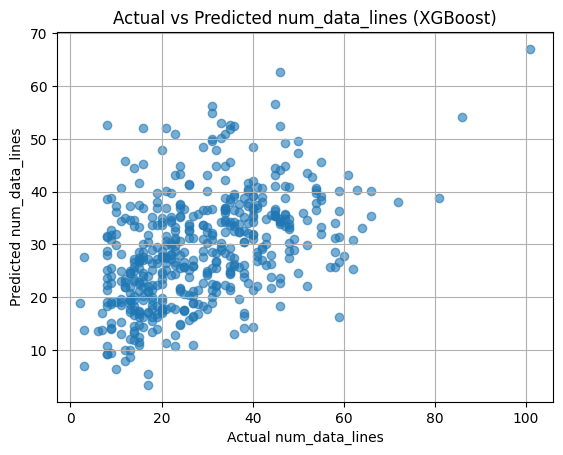

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
!pip install xgboost --quiet

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare the data
df_unique_cyclone['month'] = df_unique_cyclone['month'].astype('category')  # Only month is categorical

# Features and target
X = df_unique_cyclone[['intensity', 'latitude', 'longitude', 'pressure', 'wind', 'month']]
y = df_unique_cyclone['num_data_lines']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train using native categorical support
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    tree_method='hist',              # Required for enable_categorical
    enable_categorical=True,
    n_estimators=100,
    random_state=42
)

model.fit(X_train, y_train)

# Predict and evaluate
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Plot actual vs predicted
plt.scatter(y_test, predictions, alpha=0.6)
plt.xlabel('Actual num_data_lines')
plt.ylabel('Predicted num_data_lines')
plt.title('Actual vs Predicted num_data_lines (XGBoost)')
plt.grid(True)
plt.show()


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best params: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 50, 'xgb__subsample': 0.6}
Best CV RMSE: 12.426945686340332
Test   RMSE: 12.2945
Test     R²: 0.3120


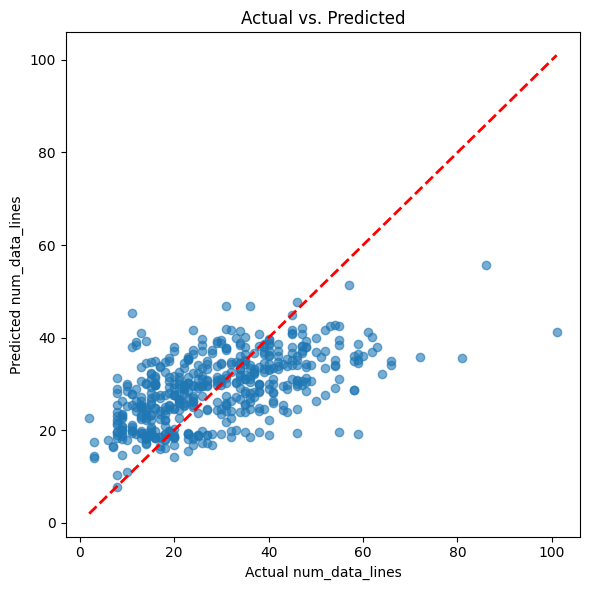

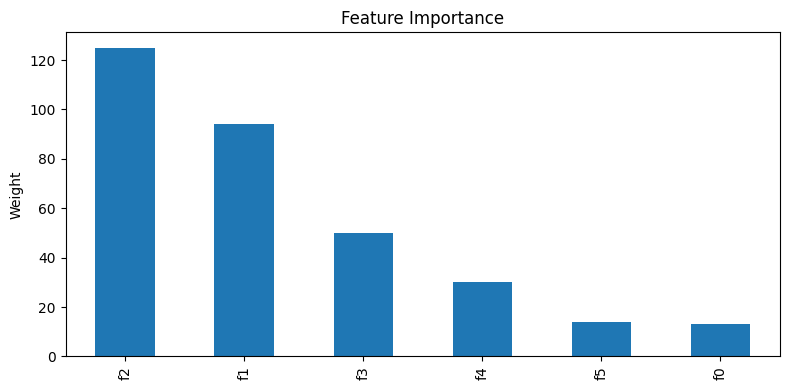

In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# Script: xgboost_num_data_lines_prediction.py
# Purpose: Train and evaluate an XGBoost model to predict `num_data_lines`
# Dependencies:
#   pip install xgboost scikit-learn matplotlib pandas
# ───────────────────────────────────────────────────────────────────────────────

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

def load_and_validate(df: pd.DataFrame) -> pd.DataFrame:
    """
    Checks for missing values and basic data sanity.
    """
    assert 'num_data_lines' in df.columns, "Target 'num_data_lines' not found."
    # Drop or impute missing rows
    df = df.dropna(subset=['intensity', 'latitude', 'longitude', 'pressure', 'time_interval', 'wind', 'num_data_lines' , 'month'])
    return df

def build_model():
    """
    Returns a scikit-learn Pipeline wrapping XGBoost with a scaler.
    """
    xgb_reg = xgb.XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        tree_method='hist',       # faster on larger data
        random_state=42
    )

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', xgb_reg)
    ])
    return pipeline

def tune_hyperparameters(pipeline, X_train, y_train):
    """
    Runs a simple grid search over key hyperparameters with 5-fold CV.
    """
    param_grid = {
        'xgb__n_estimators': [50, 100, 200],
        'xgb__max_depth': [3, 5, 7],
        'xgb__learning_rate': [0.01, 0.1, 0.2],
        'xgb__subsample': [0.6, 0.8, 1.0]
    }
    grid = GridSearchCV(
        pipeline,
        param_grid,
        scoring='neg_root_mean_squared_error',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    print("Best params:", grid.best_params_)
    print("Best CV RMSE:", -grid.best_score_)
    return grid.best_estimator_

def evaluate(model, X_test, y_test):
    """
    Prints RMSE and R², and plots Actual vs Predicted.
    """
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2   = r2_score(y_test, preds)

    print(f"Test   RMSE: {rmse:.4f}")
    print(f"Test     R²: {r2:.4f}")

    # Scatter plot
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, preds, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', linewidth=2)
    plt.xlabel("Actual num_data_lines")
    plt.ylabel("Predicted num_data_lines")
    plt.title("Actual vs. Predicted")
    plt.tight_layout()
    plt.show()

    # Feature importance
    booster = model.named_steps['xgb'].get_booster()
    fmap = booster.get_score(importance_type='weight')
    feat_imp = pd.Series(fmap).sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    feat_imp.plot(kind='bar')
    plt.title("Feature Importance")
    plt.ylabel("Weight")
    plt.tight_layout()
    plt.show()

def main(df: pd.DataFrame):
    # 1. Load & validate
    df = load_and_validate(df)

    # 2. Split
    X = df[['intensity', 'latitude', 'longitude', 'pressure', 'time_interval', 'wind']]
    y = df['num_data_lines']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 3. Build pipeline
    pipeline = build_model()

    # 4. Hyperparameter tuning
    best_model = tune_hyperparameters(pipeline, X_train, y_train)

    # 5. Final evaluation on test set
    evaluate(best_model, X_test, y_test)

if __name__ == "__main__":
    # Replace this with your actual DataFrame
    # e.g. df_unique_cyclone = pd.read_csv("cyclone_data.csv")
    #df_unique_cyclone = pd.DataFrame()  # ← load your data here
    main(df_unique_cyclone)


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.3 MB/s eta 0:00:00


In [ ]:

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# 1) Prepare data
X = df_unique_cyclone[['latitude','longitude','time_interval','wind']]
y = df_unique_cyclone['num_data_lines']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

# 2) Create a CatBoost Pool (for early stopping & categorical hints)
train_pool = Pool(X_train, y_train)
# If you had categorical columns, you’d pass cat_features=[…] here

# 3) Define base model
cb = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=20,
    verbose=100
)

# 4) Hyperparameter search (randomized)
param_dist = {
    'learning_rate':    [0.01, 0.05, 0.1, 0.2],
    'depth':            [4, 6, 8, 10],
    'l2_leaf_reg':      [1, 3, 5, 7],
    'bagging_temperature': [0, 0.5, 1, 2]
}

search = RandomizedSearchCV(
    estimator=cb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train, eval_set=[(X_test, y_test)])
print("Best params:", search.best_params_)
print("CV RMSE:", -search.best_score_)

# 5) Final evaluation
best_cb = search.best_estimator_
preds = best_cb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"Test RMSE: {rmse:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
0:	learn: 14.3833018	test: 14.5717214	best: 14.5717214 (0)	total: 3.41ms	remaining: 3.41s
100:	learn: 11.6923484	test: 12.3615687	best: 12.3615687 (100)	total: 272ms	remaining: 2.42s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 12.35690396
bestIteration = 106

Shrink model to first 107 iterations.
Best params: {'learning_rate': 0.1, 'l2_leaf_reg': 7, 'depth': 6, 'bagging_temperature': 0}
CV RMSE: 12.361595767177423
Test RMSE: 12.3569


Missing values per feature:
intensity    0
latitude     0
longitude    0
pressure     0
wind         0
month        0
dtype: int64
Final dataset shape: X=(2489, 6), y=(2489,)
Target variable statistics:
count    2489.000000
mean       29.125753
std        14.706284
min         1.000000
25%        17.000000
50%        27.000000
75%        38.000000
max       101.000000
Name: num_data_lines, dtype: float64
Training XGBoost model...
Performing hyperparameter tuning...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV score: 152.6471

MODEL EVALUATION RESULTS

TRAIN SET METRICS:
  RMSE: 11.3102
  MAE: 8.6258
  R²: 0.4055
  MAPE: 41.3552

TEST SET METRICS:
  RMSE: 12.0442
  MAE: 9.5165
  R²: 0.3398
  MAPE: 47.9495

OVERFITTING CHECK:
  RMSE difference (train - test): -0.7341
  R² difference (train - test): 0.0657
  ⚠️  Potential overfitting detected


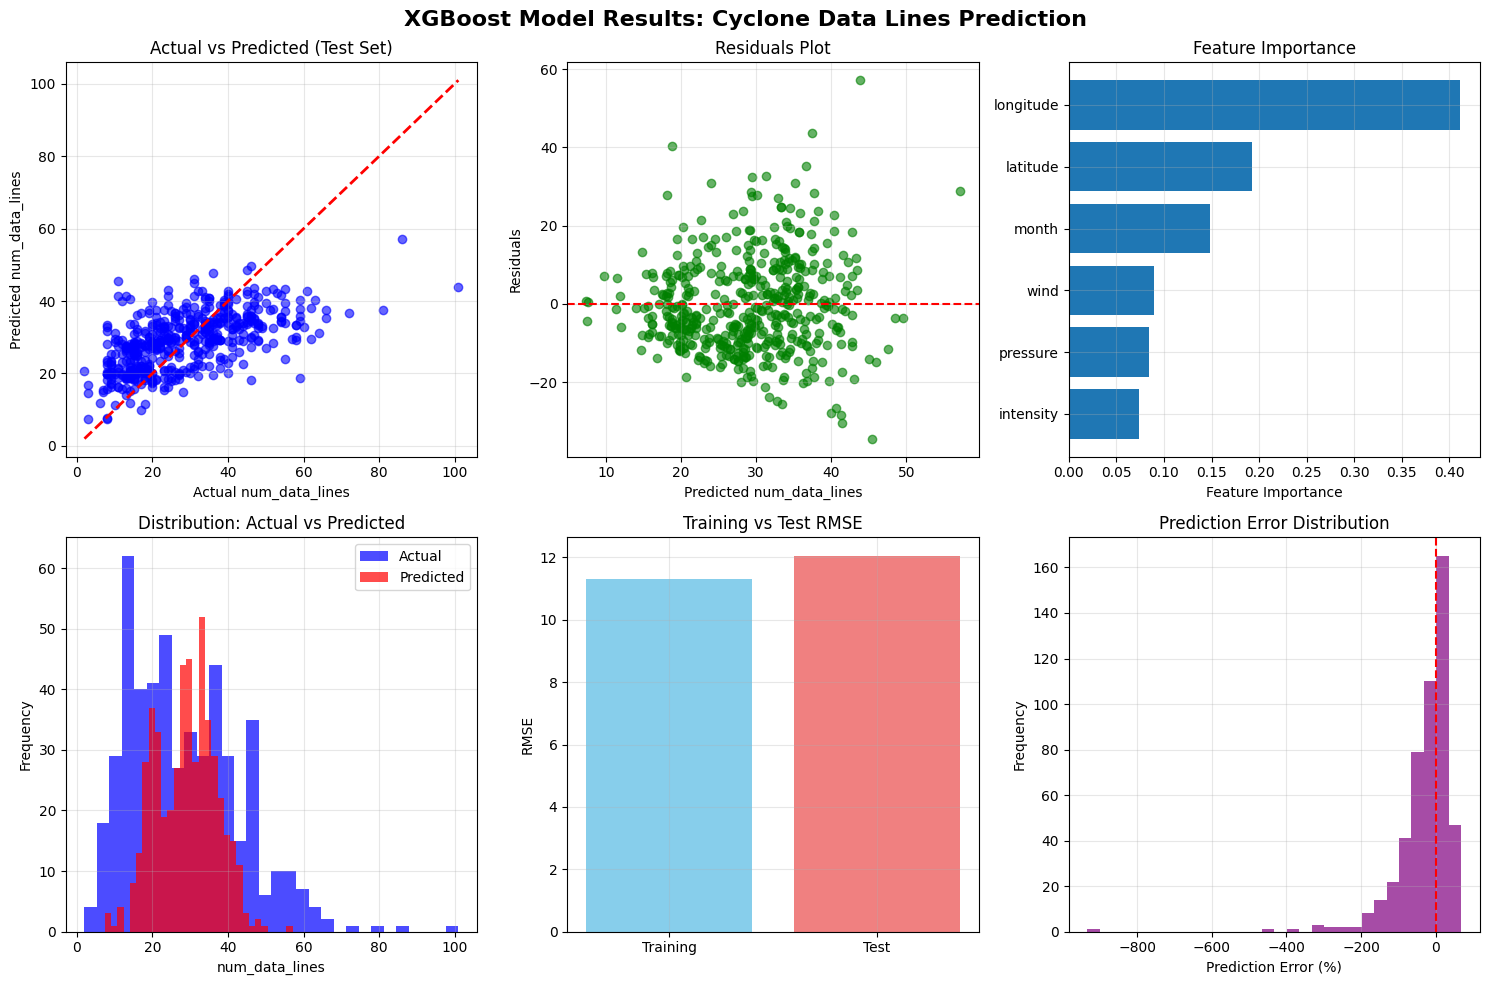


CROSS-VALIDATION RESULTS
CV RMSE: 12.4396 (+/- 1.7251)
CV RMSE scores: [11.96537108 12.97140057 12.31697613 11.20814868 13.73595585]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

class CycloneDataPredictor:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.feature_names = None

    def prepare_data(self, df, target_col='num_data_lines'):
        """
        Prepare and clean the data for modeling
        """
        # Define features
        feature_cols = ['intensity', 'latitude', 'longitude', 'pressure', 'wind' , 'month' ]

        # Check if all required columns exist
        missing_cols = [col for col in feature_cols + [target_col] if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing columns: {missing_cols}")

        # Select features and target
        X = df[feature_cols].copy()
        y = df[target_col].copy()

        # Handle missing values
        print(f"Missing values per feature:")
        print(X.isnull().sum())

        # Fill missing values with median (you might want to use more sophisticated imputation)
        X = X.fillna(X.median())

        # Remove any remaining NaN values
        mask = ~(X.isnull().any(axis=1) | y.isnull())
        X = X[mask]
        y = y[mask]

        self.feature_names = feature_cols

        print(f"Final dataset shape: X={X.shape}, y={y.shape}")
        print(f"Target variable statistics:")
        print(y.describe())

        return X, y

    def train_model(self, X, y, test_size=0.2, validate=True):
        """
        Train XGBoost model with hyperparameter tuning
        """
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=None
        )

        # Scale features (optional for tree-based models, but can help)
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        if validate:
            # Hyperparameter tuning
            print("Performing hyperparameter tuning...")
            param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 4, 5, 6],
                'learning_rate': [0.01, 0.1, 0.2],
                'subsample': [0.8, 0.9, 1.0],
                'colsample_bytree': [0.8, 0.9, 1.0]
            }

            xgb_model = xgb.XGBRegressor(
                objective='reg:squarederror',
                random_state=42,
                n_jobs=-1
            )

            grid_search = GridSearchCV(
                xgb_model, param_grid,
                cv=5, scoring='neg_mean_squared_error',
                n_jobs=-1, verbose=1
            )

            grid_search.fit(X_train_scaled, y_train)
            self.model = grid_search.best_estimator_

            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Best CV score: {-grid_search.best_score_:.4f}")
        else:
            # Use default parameters for faster training
            self.model = xgb.XGBRegressor(
                n_estimators=200,
                max_depth=4,
                learning_rate=0.1,
                subsample=0.9,
                colsample_bytree=0.9,
                objective='reg:squarederror',
                random_state=42,
                n_jobs=-1
            )
            self.model.fit(X_train_scaled, y_train)

        # Make predictions
        y_train_pred = self.model.predict(X_train_scaled)
        y_test_pred = self.model.predict(X_test_scaled)

        # Store results for evaluation
        self.results = {
            'X_train': X_train, 'X_test': X_test,
            'y_train': y_train, 'y_test': y_test,
            'y_train_pred': y_train_pred, 'y_test_pred': y_test_pred,
            'X_train_scaled': X_train_scaled, 'X_test_scaled': X_test_scaled
        }

        return self.model

    def evaluate_model(self):
        """
        Comprehensive model evaluation
        """
        if not self.model or not hasattr(self, 'results'):
            raise ValueError("Model must be trained first")

        results = self.results

        # Calculate metrics
        metrics = {}
        for split in ['train', 'test']:
            y_true = results[f'y_{split}']
            y_pred = results[f'y_{split}_pred']

            metrics[split] = {
                'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
                'MAE': mean_absolute_error(y_true, y_pred),
                'R²': r2_score(y_true, y_pred),
                'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            }

        # Print metrics
        print("\n" + "="*50)
        print("MODEL EVALUATION RESULTS")
        print("="*50)

        for split in ['train', 'test']:
            print(f"\n{split.upper()} SET METRICS:")
            for metric, value in metrics[split].items():
                print(f"  {metric}: {value:.4f}")

        # Check for overfitting
        rmse_diff = metrics['train']['RMSE'] - metrics['test']['RMSE']
        r2_diff = metrics['train']['R²'] - metrics['test']['R²']

        print(f"\nOVERFITTING CHECK:")
        print(f"  RMSE difference (train - test): {rmse_diff:.4f}")
        print(f"  R² difference (train - test): {r2_diff:.4f}")

        if rmse_diff < -0.1 or r2_diff > 0.1:
            print("  ⚠️  Potential overfitting detected")
        else:
            print("  ✅ No significant overfitting")

        return metrics

    def plot_results(self, figsize=(15, 10)):
        """
        Create comprehensive visualization of results
        """
        if not hasattr(self, 'results'):
            raise ValueError("Model must be trained first")

        results = self.results

        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle('XGBoost Model Results: Cyclone Data Lines Prediction', fontsize=16, fontweight='bold')

        # 1. Actual vs Predicted (Test Set)
        axes[0, 0].scatter(results['y_test'], results['y_test_pred'], alpha=0.6, color='blue')
        axes[0, 0].plot([results['y_test'].min(), results['y_test'].max()],
                       [results['y_test'].min(), results['y_test'].max()], 'r--', lw=2)
        axes[0, 0].set_xlabel('Actual num_data_lines')
        axes[0, 0].set_ylabel('Predicted num_data_lines')
        axes[0, 0].set_title('Actual vs Predicted (Test Set)')
        axes[0, 0].grid(True, alpha=0.3)

        # 2. Residuals Plot
        residuals = results['y_test'] - results['y_test_pred']
        axes[0, 1].scatter(results['y_test_pred'], residuals, alpha=0.6, color='green')
        axes[0, 1].axhline(y=0, color='r', linestyle='--')
        axes[0, 1].set_xlabel('Predicted num_data_lines')
        axes[0, 1].set_ylabel('Residuals')
        axes[0, 1].set_title('Residuals Plot')
        axes[0, 1].grid(True, alpha=0.3)

        # 3. Feature Importance
        if hasattr(self.model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'feature': self.feature_names,
                'importance': self.model.feature_importances_
            }).sort_values('importance', ascending=True)

            axes[0, 2].barh(importance_df['feature'], importance_df['importance'])
            axes[0, 2].set_xlabel('Feature Importance')
            axes[0, 2].set_title('Feature Importance')
            axes[0, 2].grid(True, alpha=0.3)

        # 4. Distribution of Predictions vs Actual
        axes[1, 0].hist(results['y_test'], bins=30, alpha=0.7, label='Actual', color='blue')
        axes[1, 0].hist(results['y_test_pred'], bins=30, alpha=0.7, label='Predicted', color='red')
        axes[1, 0].set_xlabel('num_data_lines')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Distribution: Actual vs Predicted')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # 5. Training vs Test Performance
        train_rmse = np.sqrt(mean_squared_error(results['y_train'], results['y_train_pred']))
        test_rmse = np.sqrt(mean_squared_error(results['y_test'], results['y_test_pred']))

        axes[1, 1].bar(['Training', 'Test'], [train_rmse, test_rmse], color=['skyblue', 'lightcoral'])
        axes[1, 1].set_ylabel('RMSE')
        axes[1, 1].set_title('Training vs Test RMSE')
        axes[1, 1].grid(True, alpha=0.3)

        # 6. Prediction Error Distribution
        error_pct = (residuals / results['y_test']) * 100
        axes[1, 2].hist(error_pct, bins=30, alpha=0.7, color='purple')
        axes[1, 2].set_xlabel('Prediction Error (%)')
        axes[1, 2].set_ylabel('Frequency')
        axes[1, 2].set_title('Prediction Error Distribution')
        axes[1, 2].axvline(x=0, color='r', linestyle='--')
        axes[1, 2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def predict_new_data(self, X_new):
        """
        Make predictions on new data
        """
        if not self.model:
            raise ValueError("Model must be trained first")

        X_new_scaled = self.scaler.transform(X_new)
        return self.model.predict(X_new_scaled)

# Usage Example
def main():
    """
    Main function to demonstrate usage
    """
    # Initialize predictor
    predictor = CycloneDataPredictor()

    try:
        # Prepare data (assumes df_unique_cyclone exists)
        X, y = predictor.prepare_data(df_unique_cyclone)

        # Train model (set validate=False for faster training)
        print("Training XGBoost model...")
        model = predictor.train_model(X, y, validate=True)

        # Evaluate model
        metrics = predictor.evaluate_model()

        # Plot results
        predictor.plot_results()

        # Cross-validation for additional validation
        print("\n" + "="*50)
        print("CROSS-VALIDATION RESULTS")
        print("="*50)

        X_scaled = predictor.scaler.transform(X)
        cv_scores = cross_val_score(predictor.model, X_scaled, y,
                                  cv=5, scoring='neg_mean_squared_error')
        cv_rmse = np.sqrt(-cv_scores)

        print(f"CV RMSE: {cv_rmse.mean():.4f} (+/- {cv_rmse.std() * 2:.4f})")
        print(f"CV RMSE scores: {cv_rmse}")

    except Exception as e:
        print(f"Error: {e}")
        print("Please ensure 'df_unique_cyclone' DataFrame is available with required columns.")

# Run the main function
if __name__ == "__main__":
    main()